<a href="https://colab.research.google.com/github/Seldarzu/ai-based-fake-image-detection/blob/main/ai_ile_sahte_gorsel_tespiti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

##  Proje Tanıtımı — **AI ile Sahte Yüz Tespiti**

###  Proje Amacı

Bu projenin amacı, **yapay zeka tarafından üretilmiş veya manipüle edilmiş sahte yüz görsellerini**, **gerçek insan yüzlerinden ayırt edebilen** bir derin öğrenme tabanlı sınıflandırma modeli geliştirmektir.
Günümüzde **Generative Adversarial Network (GAN)** ve **Diffusion** tabanlı sistemler, insan gözünün ayırt edemeyeceği kadar gerçekçi yüzler üretebilmektedir. Bu durum, kimlik sahtekarlığı, sosyal medya manipülasyonu ve dijital güvenlik açısından ciddi riskler doğurmaktadır.

Projemizde geliştirilen model, bu tür **AI tarafından üretilen yüzleri tespit edebilmek** amacıyla eğitilmiştir.
Model, giriş olarak aldığı bir yüz fotoğrafını analiz eder ve çıktıda bu görselin **“Gerçek”** ya da **“Sahte”** olduğunu tahmin eder.

---

###  Kullanılan Veri Seti — **RVF-10K (Real vs Fake Faces Dataset)**

Bu projede kullanılan **RVF-10K (Real vs Fake Faces 10K)** veri seti, **S. Kunichetty** tarafından hazırlanmış ve **Kaggle** üzerinde yayımlanmış, 10.000 adet yüz görüntüsünden oluşan **dengeli bir veri setidir**.
Veri seti, yapay zekâ destekli sahte yüz tespiti çalışmalarında eğitim ve test amacıyla kullanılmak üzere tasarlanmıştır.

(Alternatif veri seti olarak kullandığımız veri setinin atası olan **Real vs Fake Faces 140K** verisi de kullanılabilir.)

####  Veri Özeti

| Sınıf             | Açıklama                                            | Görüntü Sayısı | Kaynak                                 |
| :---------------- | :-------------------------------------------------- | :------------- | :------------------------------------- |
| **Gerçek (Real)** | Gerçek insan yüzleri                                | 5.000          | FFHQ & çeşitli açık kaynak yüz setleri |
| **Sahte (Fake)**  | Yapay zeka (StyleGAN 2) tarafından üretilmiş yüzler | 5.000          | StyleGAN 2 (NVIDIA, 2020)              |
| **Toplam**        |                                                     | **10.000**     | —                                      |

####  Görsellerin Özellikleri

* **Dosya formatı:** `.jpg`
* **Ortalama çözünürlük:** 128×128 px
* **Renk tipi:** RGB (renkli)
* **Etiketleme yapısı:**

  ```
  rvf10k/
  ├── real/
  │   ├── real_0001.jpg …
  ├── fake/
  │   ├── fake_0001.jpg …
  ```

Veri seti, **iki sınıflı (binary)** yapıdadır ve her iki sınıfta da eşit sayıda örnek bulunur; bu durum modelin dengeli bir şekilde öğrenmesini sağlar.


###  Beklenen Çıktılar

Model, bir yüz görseli aldığında şu çıktıyı üretir:

* **Gerçek (Real)** → Görsel doğal bir insan yüzüdür.
* **Sahte (Fake)** → Görsel, yapay zeka tarafından üretilmiştir.

---

###  Veri Setinin Avantajları

* **Dengeli dağılım (50/50)** → Sınıf dengesizliği problemi yok.
* **Küçük boyut** → Hızlı indirme ve eğitme imkanı.
* **Temiz veri** → Gürültü ve etiket hatası az.
* **Açık kaynak** → Lisans problemi olmadan araştırmalarda kullanılabilir.
* **Yüksek doğruluk potansiyeli** → Modern CNN veya Vision Transformer modelleriyle kolayca > 95 % doğruluk elde edilebilir.

---

###  Kaynak

* Kaggle veri seti: [RVF-10K – Real vs Fake Faces Dataset](https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k)
* StyleGAN 2: Karras et al., *“Analyzing and Improving the Image Quality of StyleGAN”*, CVPR 2020.
* FFHQ (Flickr-Faces-HQ) Dataset, NVIDIA, 2019.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dataset_path = '/content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k'


if os.path.exists(dataset_path):
    print(f"✅ Dataset bulundu: {dataset_path}\nAlt klasörler:")
    for folder in os.listdir(dataset_path):
        print("  ├──", folder, "→", os.listdir(os.path.join(dataset_path, folder)))
else:
    print(f"❌ Dataset path not found: {dataset_path}")

✅ Dataset bulundu: /content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k
Alt klasörler:
  ├── train → ['fake', 'real']
  ├── valid → ['fake', 'real']


EDA’nın amacı:

Verinin yapısını, sınıf dağılımını, örnek görselleri, piksel özelliklerini ve olası dengesizlikleri anlamaktır.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from PIL import Image


In [ ]:
dataset_path = '/content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k'
train_dir = os.path.join(dataset_path, 'train')
val_dir   = os.path.join(dataset_path, 'valid')

print("📂 Veri seti konumu:", dataset_path)
print("Alt klasörler:", os.listdir(dataset_path))

print("\n📊 Eğitim klasöründeki alt klasörler:", os.listdir(train_dir))
print("📊 Doğrulama klasöründeki alt klasörler:", os.listdir(val_dir))


📂 Veri seti konumu: /content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k
Alt klasörler: ['train', 'valid']

📊 Eğitim klasöründeki alt klasörler: ['fake', 'real']
📊 Doğrulama klasöründeki alt klasörler: ['fake', 'real']


Her sınıftaki görsel sayısını inceleyelim

Eğitim veri dağılımı: {'fake': 3500, 'real': 3509}
Doğrulama veri dağılımı: {'fake': 1500, 'real': 1500}


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


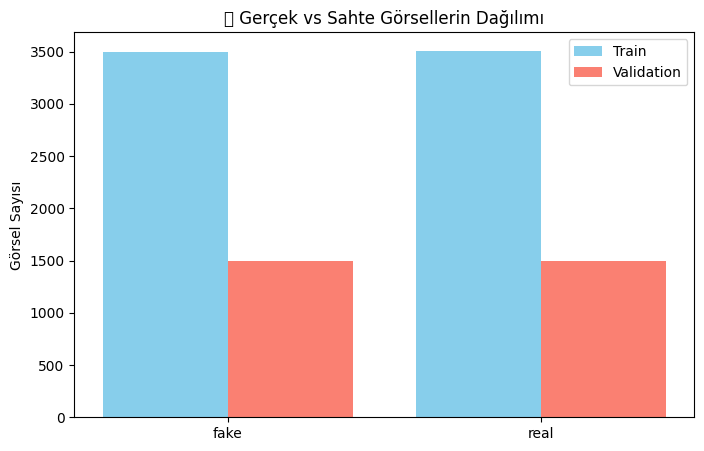

In [ ]:
def count_images(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        counts[cls] = len(os.listdir(cls_path))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)

print("Eğitim veri dağılımı:", train_counts)
print("Doğrulama veri dağılımı:", val_counts)

# Görselleştirelim
labels = list(train_counts.keys())
train_vals = list(train_counts.values())
val_vals = list(val_counts.values())

plt.figure(figsize=(8,5))
x = np.arange(len(labels))
plt.bar(x-0.2, train_vals, width=0.4, label='Train', color='skyblue')
plt.bar(x+0.2, val_vals, width=0.4, label='Validation', color='salmon')
plt.xticks(x, labels)
plt.title("📊 Gerçek vs Sahte Görsellerin Dağılımı")
plt.ylabel("Görsel Sayısı")
plt.legend()
plt.show()


Örnek Görseller

🖼️ Gerçek yüz örnekleri:


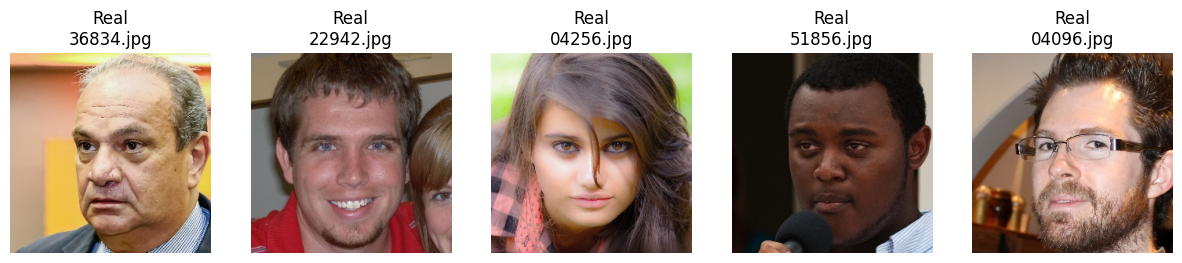

🖼️ Sahte yüz örnekleri:


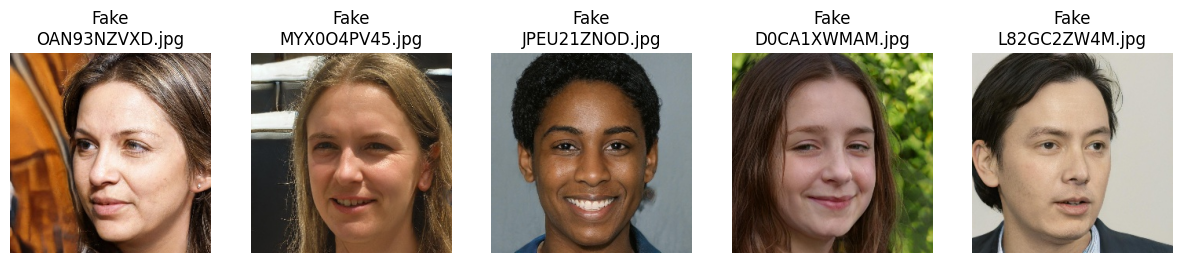

In [ ]:
def show_examples(folder, title, n=5):
    images = os.listdir(folder)
    plt.figure(figsize=(15,3))
    for i in range(n):
        img_path = os.path.join(folder, random.choice(images))
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title}\n{os.path.basename(img_path)}")
    plt.show()

print("🖼️ Gerçek yüz örnekleri:")
show_examples(os.path.join(train_dir, 'real'), 'Real', 5)

print("🖼️ Sahte yüz örnekleri:")
show_examples(os.path.join(train_dir, 'fake'), 'Fake', 5)

Gerçek yüzlerde genelde doku, saç çizgisi, diş ve ışık geçişleri daha doğal görünür.

Sahte (AI-generated) yüzlerde asimetriler, arka plan bozulmaları veya bulanıklık olabilir.
Bu farkları modelin öğrenmesini bekliyoruz.

**Görsellerin ortalama boyutu ve renk istatistikleri**

In [ ]:
import cv2
import numpy as np

def get_image_stats(folder, n=500):
    widths, heights = [], []
    means, stds = [], []
    files = os.listdir(folder)[:n]
    for f in files:
        img = cv2.imread(os.path.join(folder, f))
        if img is None:
            continue
        h, w, _ = img.shape
        widths.append(w)
        heights.append(h)
        means.append(np.mean(img))
        stds.append(np.std(img))
    return np.mean(widths), np.mean(heights), np.mean(means), np.mean(stds)

real_stats = get_image_stats(os.path.join(train_dir, 'real'))
fake_stats = get_image_stats(os.path.join(train_dir, 'fake'))

print("Gerçek yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std):", real_stats)
print("Sahte yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std):", fake_stats)


Gerçek yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std): (np.float64(256.0), np.float64(256.0), np.float64(112.25718003336587), np.float64(62.52541689058048))
Sahte yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std): (np.float64(256.0), np.float64(256.0), np.float64(112.17039586385093), np.float64(60.56716517989336))
